#BASIC IMPORTS

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pickle
from IPython.display import clear_output
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from torch import optim
from sklearn.preprocessing import MinMaxScaler

In [8]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
N = 50
threshold_min_mag = 3

#PREPROCESSING FUNCTIONS

In [10]:
def check_nan(dataf,col_name):
    return np.unique(np.isnan(np.array(dataf[col_name])),return_counts=True)

In [11]:
def check_all_nan(dataf):
    d={}
    for col in dataf.columns:
        if col=="DATE" or col=="TIME" or col=="DATETIME":
            continue
        temp = check_nan(dataf,col)
        if len(temp[0])>1:
            d[col] = temp[1][1]
    if bool(d):
        print("nan found in the following columns")
        print(d)
    else:
        print("nan not found")

In [12]:
def get_root_energy(mag):
    energy = 11.8+(1.5*mag)
    energy = 10**energy
    return energy**0.5

In [13]:
def no_of_events(dataf,mag,i,N=50):
    count=0
    if i-N<0:
        K=0
    else:
        K=i-N
    for j in range(K,i):
        if(dataf.iloc[j]["MAG"]>=mag):
            count+=1
    if count==0:
        count=1
    return count

In [14]:
def calc_mu(dataf,i,char_mag=3.5,N=50):
    count=0
    char_times=[]
    if i-N<0:
        K=0
    else:
        K=i-N
    for j in range(K,i):
        if(dataf.iloc[j]["MAG"]>=char_mag):
            count+=1
            if count>1:
                #print(dataf.iloc[j]["DATE"]-last_time)
                temp = dataf.iloc[j]["DATE"]-last_time
                temp = int(str(temp).split()[0])
                char_times.append(temp)
            last_time = dataf.iloc[j]["DATE"]
    if count==0:
        count=1
    mu = sum(np.array(char_times))/count
    if mu==0:
        mu=-100                 #check and change
    c = np.std(np.array(char_times))/mu
    if math.isnan(c):
        c=-100
    return mu,c

In [15]:
def process_data(dataf,N=N):
    
    convert_dict = {"DATE":str,"TIME":str}
    dataf = dataf.astype(convert_dict)
    dataf['DATETIME'] = dataf["DATE"] + " " + dataf["TIME"]
    dataf['DATETIME'] = pd.to_datetime(dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')
    dataf["DATE"] = pd.to_datetime(dataf["DATE"])
    
    min_mag = np.min(np.array(dataf["MAG"]))
    mean_mag = np.mean(np.array(dataf["MAG"]))
    b_VAL = np.log10(np.exp(1))/(mean_mag-min_mag)
    
    dataf["TVAL"] = 0
    dataf["MEAN_MAG"] = 0
    dataf["ENERGY"] = 0
    dataf["b"] = b_VAL
    dataf["MAG_DEF"]=0
    dataf["ETA"] = 0
    dataf["MU"] = 0
    dataf["c"] = 0

    dataf["NO_OF_EVENTS"] = 1

    for i in range(N,len(dataf)):
        tval = (dataf.iloc[i]["DATETIME"]-dataf.iloc[i-N]["DATETIME"]).days + (dataf.iloc[i]["DATETIME"]-dataf.iloc[i-N]["DATETIME"]).seconds/(60*60*24)
        dataf.loc[i,("TVAL")] = tval
        dataf.loc[i,("MEAN_MAG")] = sum(dataf.iloc[i-N:i]["MAG"])/N
        dataf.loc[i,("ENERGY")] = sum(get_root_energy(dataf.iloc[i-N:i]["MAG"]))/dataf.iloc[i]["TVAL"]

        
        dataf.loc[i,"NO_OF_EVENTS"] = no_of_events(dataf,dataf.iloc[i]["MAG"],i)
        dataf.loc[i,"MAG_DEF"] = np.max(np.array(dataf.iloc[i-N:i]["MAG"]))
        dataf.loc[i,"MU"],dataf.loc[i,"c"] = calc_mu(dataf,i)

    a_VAL = sum(np.log10(np.array(dataf["NO_OF_EVENTS"])) + b_VAL*(np.array(dataf["MAG"])))/len(dataf)
    M_exp = a_VAL/b_VAL

    dataf["MAG_DEF"] = np.array(dataf["MAG_DEF"]) - M_exp

    predicted = a_VAL-b_VAL*np.array(dataf["MAG"])
    real = np.log10(np.array(dataf["NO_OF_EVENTS"])) 
    eta = (real-predicted)**2/N-1
    dataf["ETA"] = eta

    return dataf

In [16]:
def func(x):
    return (x-x.min())/(x.max()-x.min())        

In [17]:
def scale_data(dataf):
    output_dataf = dataf.aggregate(func,0)
    output_dataf["b"] = dataf.iloc[0]["b"]
    return output_dataf

In [18]:
def get_output(dataf,req_mag,future_days=30):
    temp_dataf = dataf.copy(deep=True)
    temp_dataf["OUTPUT"] = 0
    for i in range(len(temp_dataf)-future_days):
        for j in range(i,i+future_days):
            if temp_dataf.iloc[j]["MAG"]>=req_mag:
                temp_dataf.loc[i,"OUTPUT"] = 1
                break
    return temp_dataf["OUTPUT"]

In [19]:
def remove_illegal_rows(dataf):
    count=0
    rem_rows=[]
    for i in range(len(dataf)):
        if dataf.iloc[i]["MU"]==-100:
            rem_rows.append(i)
            count+=1
        if dataf.iloc[i]["c"]==-100:
            rem_rows.append(i)
            count+=1
            
    dataf = dataf.drop(rem_rows,axis=0)
    print(count)
    print(rem_rows)
    return dataf

#TRAINING FUNCTIONS

In [21]:
def fit_optim(net,X_train,Y_train,epochs=1000,lr=0.0001,mini_batch=64,wd=1e-5,loss_fn=nn.BCELoss(),display=True,device="cpu"):
    loss_arr=[]
    accuracy_arr=[]
    torch.autograd.set_detect_anomaly(True)
    opt = optim.Adam(net.parameters(),lr=lr,weight_decay=wd)
    min_loss=10000
    opt.zero_grad()
    for i in range(epochs):
        j=0
        while j<len(X_train):
            y_hat = net(X_train[j:j+mini_batch,:])
            loss = loss_fn(y_hat.squeeze(),Y_train.squeeze()[j:j+mini_batch])    
            loss.backward()
            opt.step()
            if loss<min_loss:
                min_loss=loss
                print("The minimum loss is changed to",min_loss)
                best_model=net
            j+=mini_batch
            

        loss_arr.append(loss.item())

        if display and (i%5==0):
            clear_output(wait=True)
            print('Iteration',i,'Loss',loss_arr[-1])
            plt.figure()
            plt.plot(loss_arr[0:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
        
        

    print('The loss before training is' + str(loss_arr[0]))
    print('The loss after training is' + str(min_loss))
    return loss_arr,best_model

**ACCURACY METRICS**

In [22]:
def calc_metric(net,X_val,Y_val):
    net.eval()
    temp = net(X_val)
    for i in range(len(temp)):
        if temp[i]>0.5:
            temp[i]=1
        else:
            temp[i]=0
    pred = temp.detach()
    print("The accuracy is ",accuracy_score(Y_val,pred)*100)
    print("The confusion matrix is\n",confusion_matrix(Y_val,pred))
    print("The f1 score is",f1_score(Y_val,pred))

In [85]:
def calc_metric2(net,X_val,Y_val):
    net.eval()
    temp = net(X_val)
    for i in range(len(temp)):
        if temp[i]>0.5:
            temp[i]=1
        else:
            temp[i]=0
    pred = temp.detach()
    print("The f1 accuracy is",f1_score(Y_val,pred))

#HIMALAYAN DATA

In [ ]:
dataf = pd.read_csv('Dataset Earthquake(3 greater).txt',error_bad_lines=False)
dataf.head()

,EVENTID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,DEPFIX,AUTHOR .1,TYPE,MAG
0,589363,NDI,1982-11-21,08:10:21,28.80,81.05,,,NDI,ML,3.6
1,500434,NDI,1986-03-13,20:58:43,28.60,80.60,,,NDI,mL,3.3
2,495770,NEIC,1986-05-16,05:16:13.70,34.00,72.58,15.0,TRUE,NEIC,mL,4.0
3,490430,QUE,1986-07-10,07:56:12,34.15,72.69,2.0,,QUE,mL,4.5
4,384489,BJI,1989-12-20,21:47:53.50,36.82,73.85,23.0,,BJI,mL,4.2


SIMPLE PREPROCESSING

In [ ]:
dataf = dataf.drop(["EVENTID","AUTHOR   ","AUTHOR   .1","DEPFIX","TYPE  "],axis=1)

In [ ]:
dataf = dataf.rename(columns={'DATE      ':'DATE',
                              'TIME       ':'TIME',
                              'LAT     ':'LAT',
                              'LON      ':'LONG',
                              'MAG ':'MAG'})

In [ ]:
def clean_column(data,colname):
    depth_list=[]
    for i in range(len(data)):

        if data.iloc[i][colname].strip()=='':
            depth_list.append(0)
        elif data.iloc[i][colname].strip()=='9999999999':
            depth_list.append(0)
        else:
            depth_list.append(float(data.iloc[i][colname].strip()))

    return depth_list

In [ ]:
dataf["DEPTH"] = clean_column(dataf,"DEPTH")

In [ ]:
himalaya_dataf = process_data(dataf)

In [ ]:
himalaya_dataf = remove_illegal_rows(himalaya_dataf)

2
[929, 930]


In [ ]:
himalaya_dataf

,DATE,TIME,LAT,LONG,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,1982-11-21,08:10:21,28.8000,81.0500,0.0,3.6,1982-11-21 08:10:21.000,0.000000,0.000,0.000000e+00,1.11044,-4.543166,-0.978062,0.000000,0.000000,1
1,1986-03-13,20:58:43,28.6000,80.6000,0.0,3.3,1986-03-13 20:58:43.000,0.000000,0.000,0.000000e+00,1.11044,-4.543166,-0.961886,0.000000,0.000000,1
2,1986-05-16,05:16:13.70,34.0000,72.5800,15.0,4.0,1986-05-16 05:16:13.700,0.000000,0.000,0.000000e+00,1.11044,-4.543166,-0.992724,0.000000,0.000000,1
3,1986-07-10,07:56:12,34.1500,72.6900,2.0,4.5,1986-07-10 07:56:12.000,0.000000,0.000,0.000000e+00,1.11044,-4.543166,-0.999954,0.000000,0.000000,1
4,1989-12-20,21:47:53.50,36.8200,73.8500,23.0,4.2,1989-12-20 21:47:53.500,0.000000,0.000,0.000000e+00,1.11044,-4.543166,-0.997096,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,2019-12-30,17:39:14.17,35.4938,74.4632,0.0,3.2,2019-12-30 17:39:14.170,103.656713,3.420,1.829378e+08,1.11044,-0.143166,-0.999945,5.882353,1.306486,35
1558,2019-12-30,18:25:29.06,35.4915,74.4716,0.0,3.0,2019-12-30 18:25:29.060,102.917662,3.418,1.838860e+08,1.11044,-0.143166,-0.999996,5.882353,1.306486,50
1559,2019-12-30,20:25:30.77,35.6541,74.4530,0.0,3.1,2019-12-30 20:25:30.770,100.775451,3.416,1.875307e+08,1.11044,-0.143166,-1.000000,5.882353,1.306486,40
1560,2019-12-31,00:52:46.57,35.3951,74.8048,0.0,3.3,2019-12-31 00:52:46.570,97.563067,3.406,1.913457e+08,1.11044,-0.143166,-0.999911,6.000000,1.319091,28


In [ ]:
#himalaya_dataf.to_csv("himalaya_dataf.csv")

In [ ]:
himalaya_output = get_output(himalaya_dataf,4.3)
pd_dict = {"OUTPUT":himalaya_output}
himalaya_dataf_output = pd.DataFrame(pd_dict)
himalaya_dataf_output.to_csv("himalaya4.3_output.csv")

In [ ]:
himalaya2_output = get_output(himalaya_dataf,5.5)
pd_dict2 = {"OUTPUT":himalaya2_output}
himalaya2_dataf_output = pd.DataFrame(pd_dict2)
himalaya2_dataf_output.to_csv("himalaya5.5_output.csv")

#HIMALAYAN DATA VISUALIZATION

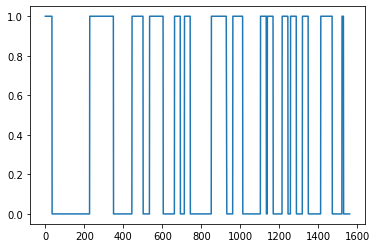

In [ ]:
plt.plot(dataf["OUTPUT"])
plt.show()

GUTENBERG RICHTER LAW VISUALIZATION

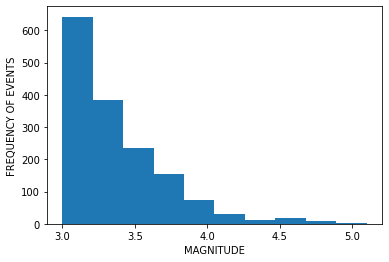

In [ ]:
plt.hist(dataf["MAG"])
plt.xlabel("MAGNITUDE")
plt.ylabel("FREQUENCY OF EVENTS")
plt.show()

T VALUES (SEISMICITY INDICATOR)

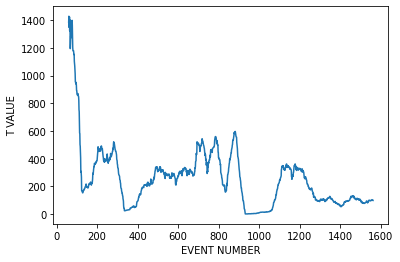

In [ ]:
plt.plot(dataf.loc[60:,("TVAL")])
plt.xlabel("EVENT NUMBER")
plt.ylabel("T VALUE")
plt.show()

MEAN MAGNITUDE (SEISMICITY INDICATOR)

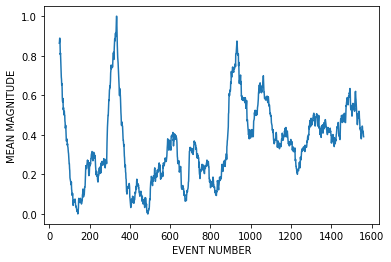

In [ ]:
plt.plot(final_dataf["MEAN_MAG"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MEAN MAGNITUDE")
plt.show()

ENERGY ((SEISMICITY INDICATOR)

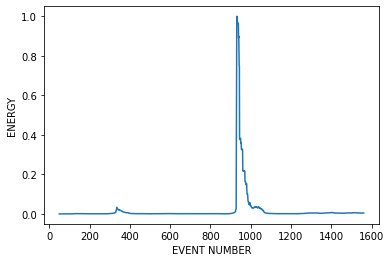

In [ ]:
plt.plot(final_dataf["ENERGY"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("ENERGY")
plt.show()

ETA VALUE (SEISMICITY INDICATOR)

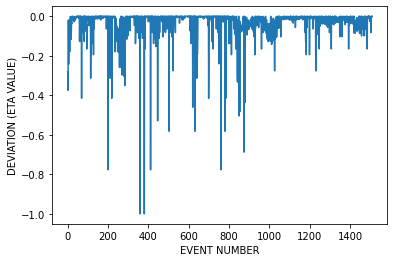

In [ ]:
plt.plot(np.array(final_dataf["ETA"])*-1)
plt.xlabel("EVENT NUMBER")
plt.ylabel("DEVIATION (ETA VALUE)")
plt.show()

MAGNITUDE DEFICIT (SEISMICITY INDICATOR)

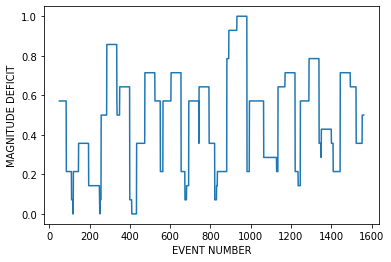

In [ ]:
plt.plot(final_dataf["MAG_DEF"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MAGNITUDE DEFICIT")
plt.show()

#HIMALAYAN DATA MODEL TRAINING 

In [ ]:
class earthquake_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8,24),
            nn.ReLU(),
            nn.Linear(24,24),
            nn.ReLU(),
            nn.Linear(24,12),
            nn.ReLU(),
            nn.Linear(12,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

**SPLIT DATA INTO TRAIN AND VALIDATION SETS**

In [ ]:
arr_in = np.zeros((len(final_dataf),8))
arr_out = np.zeros((len(final_dataf),1)) 
for i in range(len(final_dataf)):
    arr_in[i] = np.array(final_dataf.iloc[i])
    arr_out[i] = dataf.iloc[i+N]["OUTPUT"]

In [ ]:
X_train,X_val,Y_train,Y_val = train_test_split(arr_in,arr_out,random_state=0)

In [ ]:
X_train,X_val,Y_train,Y_val = map(torch.Tensor,(X_train,X_val,Y_train,Y_val))

**TRAINING MODEL**

In [ ]:
model = earthquake_model()
opt = optim.Adam(model.parameters(),lr=0.0001)
loss_fn = nn.BCELoss()

Iteration 1995 Loss 0.22672905027866364


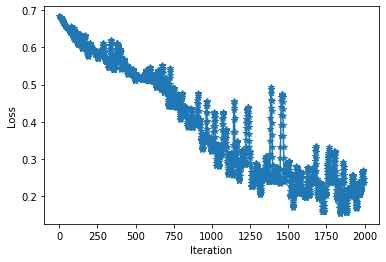




The loss before training is0.6839534044265747
The loss after training is0.19851984083652496


In [ ]:
l,bm = fit_optim(model,2000)

**RESULTS**

In [ ]:
temp = bm(X_val)
for i in range(len(temp)):
    if temp[i]>0.5:
        temp[i]=1
    else:
        temp[i]=0
print("The accuracy after 2000 epochs is ",accuracy_score(temp.detach(),Y_val))

In [ ]:
torch.save(bm2,'Earthquake_Model_4(90.4%)')

In [ ]:
saved_model = torch.load("Earthquake_Model_4(90.4%)")

In [ ]:
calc_metric(saved_model,X_val,Y_val)

The accuracy after 2000 epochs is  90.47619047619048
[[192  15]
 [ 21 150]]
0.8928571428571428


Iteration 3995 Loss 0.1457221359014511


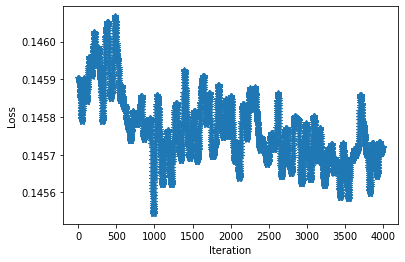




The loss before training is0.14590245485305786
The loss after training is0.1457282155752182


In [ ]:
#l2,bm2 = fit_optim(model,4000)

#SUMATRA DATA

In [ ]:
sumatra_dataf = pd.read_excel('Sumatra.xlsx')
sumatra_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1970-01-01,03:29:16.800000,-4.9300,102.7330,58.0,5.4
1,1970-01-06,23:26:47.200000,-7.6830,107.0690,90.0,4.8
2,1970-01-07,13:53:52.400000,-1.8460,100.3990,40.0,5.2
3,1970-01-16,02:27:30.100000,-7.1800,106.5520,92.0,5.1
4,1970-01-21,03:34:04.600000,7.5610,94.2650,19.0,5.0
...,...,...,...,...,...,...
21852,2020-08-24,10:24:30.430000,-3.9355,101.0578,0.0,5.0
21853,2020-08-25,23:27:55.840000,-6.4711,104.7137,17.3,5.1
21854,2020-08-26,02:36:54.130000,-5.0410,102.8504,0.0,4.3
21855,2020-08-29,05:35:40.410000,-4.1794,101.1399,0.0,4.9


**SIMPLE PREPROCESSING**

In [ ]:
sumatra_dataf = sumatra_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
sumatra_dataf = sumatra_dataf.astype(convert_dict)

In [ ]:
sumatra_dataf['DATETIME'] = sumatra_dataf["DATE"] + " " + sumatra_dataf["TIME"]
sumatra_dataf['DATETIME'] = pd.to_datetime(sumatra_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
sumatra_dataf["DATE"] = pd.to_datetime(sumatra_dataf["DATE"])

In [ ]:
sumatra_dataf

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME
0,1970-01-01,03:29:16.800000,-4.9300,102.7330,58.0,5.4,1970-01-01 03:29:16.800
1,1970-01-06,23:26:47.200000,-7.6830,107.0690,90.0,4.8,1970-01-06 23:26:47.200
2,1970-01-07,13:53:52.400000,-1.8460,100.3990,40.0,5.2,1970-01-07 13:53:52.400
3,1970-01-16,02:27:30.100000,-7.1800,106.5520,92.0,5.1,1970-01-16 02:27:30.100
4,1970-01-21,03:34:04.600000,7.5610,94.2650,19.0,5.0,1970-01-21 03:34:04.600
...,...,...,...,...,...,...,...
21852,2020-08-24,10:24:30.430000,-3.9355,101.0578,0.0,5.0,2020-08-24 10:24:30.430
21853,2020-08-25,23:27:55.840000,-6.4711,104.7137,17.3,5.1,2020-08-25 23:27:55.840
21854,2020-08-26,02:36:54.130000,-5.0410,102.8504,0.0,4.3,2020-08-26 02:36:54.130
21855,2020-08-29,05:35:40.410000,-4.1794,101.1399,0.0,4.9,2020-08-29 05:35:40.410


In [ ]:
sumatra_dataf = process_data(sumatra_dataf)

In [ ]:
sumatra_dataf.head()

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,NO_OF_EVENTS,b,ETA,MAG_DEF,MU,c
0,1970-01-01 00:00:00.000,03:29:16.800000,-4.930,102.733,58.0,5.4,1970-01-01 03:29:16.800,0.0,0.0,0.0,1,0.682507,-0.987617,-6.552883,0.0,0.0
1,1970-01-06 00:00:00.000,23:26:47.200000,-7.683,107.069,90.0,4.8,1970-01-06 23:26:47.200,0.0,0.0,0.0,1,0.682507,-0.971375,-6.552883,0.0,0.0
2,1970-01-07 00:00:00.000,13:53:52.400000,-1.846,100.399,40.0,5.2,1970-01-07 13:53:52.400,0.0,0.0,0.0,1,0.682507,-0.982948,-6.552883,0.0,0.0
3,1970-01-16 00:00:00.000,02:27:30.100000,-7.180,106.552,92.0,5.1,1970-01-16 02:27:30.100,0.0,0.0,0.0,1,0.682507,-0.980334,-6.552883,0.0,0.0
4,1970-01-21 00:00:00.000,03:34:04.600000,7.561,94.265,19.0,5.0,1970-01-21 03:34:04.600,0.0,0.0,0.0,1,0.682507,-0.977534,-6.552883,0.0,0.0


In [ ]:
check_all_nan(sumatra_dataf)

nan not found


In [ ]:
sumatra_dataf=remove_illegal_rows(sumatra_dataf)

0
[]


In [ ]:
#sumatra_dataf.to_csv("sumatra_dataf.csv")

**OUTPUT**

In [ ]:
sumatra_output = get_output(sumatra_dataf,5.5)
pd_dict = {"OUTPUT":sumatra_output}
sumatra_dataf_output = pd.DataFrame(pd_dict)
sumatra_dataf_output.to_csv("sumatra5.5_output.csv")

In [ ]:
np.unique(np.array(sumatra_output),return_counts=True)

(array([0, 1]), array([ 7031, 14826]))

#SUMATRA DATA VISUALIZATION

GUTENBERG RICHTER LAW VISUALIZATION

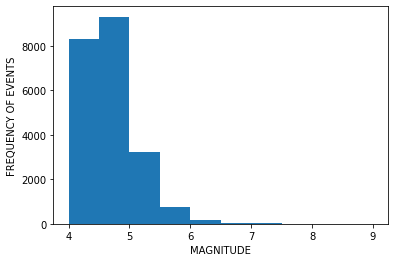

In [ ]:
plt.hist(sumatra_dataf["MAG"])
plt.xlabel("MAGNITUDE")
plt.ylabel("FREQUENCY OF EVENTS")
plt.show()

T VALUES (SEISMICITY INDICATOR)

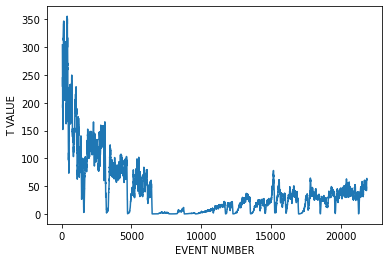

In [ ]:
plt.plot(sumatra_dataf.loc[60:,("TVAL")])
plt.xlabel("EVENT NUMBER")
plt.ylabel("T VALUE")
plt.show()

MEAN MAGNITUDE (SEISMICITY INDICATOR)

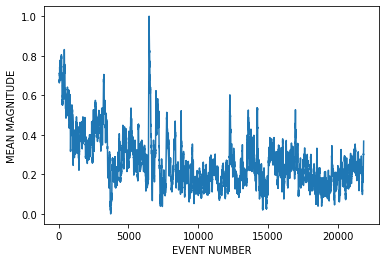

In [ ]:
plt.plot(final_dataf["MEAN_MAG"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MEAN MAGNITUDE")
plt.show()

ENERGY ((SEISMICITY INDICATOR)

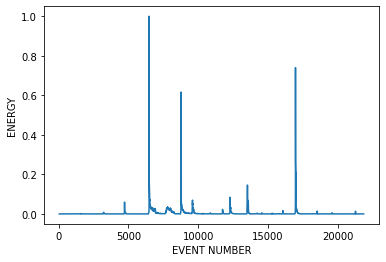

In [ ]:
plt.plot(final_dataf["ENERGY"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("ENERGY")
plt.show()

ETA VALUE (SEISMICITY INDICATOR)

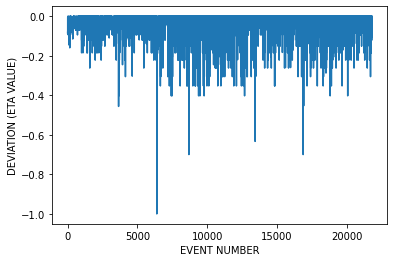

In [ ]:
plt.plot(np.array(final_dataf["ETA"])*-1)
plt.xlabel("EVENT NUMBER")
plt.ylabel("DEVIATION (ETA VALUE)")
plt.show()

MAGNITUDE DEFICIT (SEISMICITY INDICATOR)

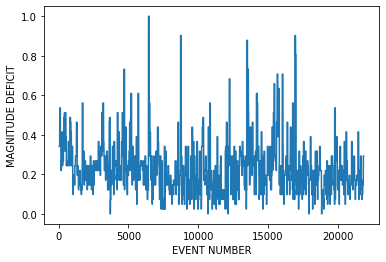

In [ ]:
plt.plot(final_dataf["MAG_DEF"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MAGNITUDE DEFICIT")
plt.show()

#SULAWESI DATA

**MIN 3.5 DATA**

In [ ]:
sulawesi_dataf = pd.read_excel('Sulawesi Min3.5 data.xlsx')
sulawesi_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1963-02-06,00:00:00,0.000,124.000,139.0,4.2
1,1963-02-10,00:00:00,4.100,126.300,40.0,4.3
2,1963-02-14,00:00:00,-7.400,128.200,197.0,5.3
3,1963-02-18,00:00:00,0.800,125.100,56.0,4.3
4,1963-02-21,00:00:00,0.800,126.700,107.0,4.4
...,...,...,...,...,...,...
34622,2019-12-27,00:00:00,2.889,127.343,75.0,4.5
34623,2019-12-28,00:00:00,1.550,128.570,41.0,5.0
34624,2019-12-29,00:00:00,4.690,125.480,10.0,5.2
34625,2019-12-29,00:00:00,4.670,125.450,22.0,4.8


In [ ]:
sulawesi_dataf = sulawesi_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
sulawesi_dataf = sulawesi_dataf.astype(convert_dict)

In [ ]:
sulawesi_dataf['DATETIME'] = sulawesi_dataf["DATE"] + " " + sulawesi_dataf["TIME"]
sulawesi_dataf['DATETIME'] = pd.to_datetime(sulawesi_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
sulawesi_dataf["DATE"] = pd.to_datetime(sulawesi_dataf["DATE"])

In [ ]:
sulawesi_dataf = process_data(sulawesi_dataf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
sulawesi_dataf

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,1963-02-06,00:00:00,0.000,124.000,139.0,4.2,1963-02-06,0,0.000,0.000000e+00,0.446588,-7.391975,-0.959359,0.00,0.000000,1
1,1963-02-10,00:00:00,4.100,126.300,40.0,4.3,1963-02-10,0,0.000,0.000000e+00,0.446588,-7.391975,-0.961866,0.00,0.000000,1
2,1963-02-14,00:00:00,-7.400,128.200,197.0,5.3,1963-02-14,0,0.000,0.000000e+00,0.446588,-7.391975,-0.982543,0.00,0.000000,1
3,1963-02-18,00:00:00,0.800,125.100,56.0,4.3,1963-02-18,0,0.000,0.000000e+00,0.446588,-7.391975,-0.961866,0.00,0.000000,1
4,1963-02-21,00:00:00,0.800,126.700,107.0,4.4,1963-02-21,0,0.000,0.000000e+00,0.446588,-7.391975,-0.964292,0.00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34622,2019-12-27,00:00:00,2.889,127.343,75.0,4.5,2019-12-27,43,4.624,3.857924e+09,0.446588,-1.491975,-0.999311,0.82,1.422758,30
34623,2019-12-28,00:00:00,1.550,128.570,41.0,5.0,2019-12-28,44,4.638,3.800274e+09,0.446588,-1.491975,-0.999907,0.86,1.362383,10
34624,2019-12-29,00:00:00,4.690,125.480,10.0,5.2,2019-12-29,45,4.660,3.800234e+09,0.446588,-1.491975,-0.999194,0.88,1.323722,6
34625,2019-12-29,00:00:00,4.670,125.450,22.0,4.8,2019-12-29,45,4.656,3.742391e+09,0.446588,-1.491975,-0.999809,0.90,1.286336,18


In [ ]:
check_all_nan(sulawesi_dataf)

nan not found


In [ ]:
#sulawesi_dataf.to_csv("sulawesi3.5_dataf.csv")

In [ ]:
sulawesi_output = get_output(sulawesi_dataf,5.5)
pd_dict = {"OUTPUT":sulawesi_output}
sulawesi_dataf_output = pd.DataFrame(pd_dict)
sulawesi_dataf_output.to_csv("sulawesi5.5_output.csv")

In [ ]:
np.unique(np.array(sulawesi_dataf_output),return_counts=True)

(array([0, 1]), array([15577, 19050]))

**MIN 4 DATA**


In [ ]:
sulawesi2_dataf = pd.read_excel('Sulawesi Min4 data.xlsx')
sulawesi2_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1963-02-06,00:00:00,0.000,124.000,139.0,4.2
1,1963-02-10,00:00:00,4.100,126.300,40.0,4.3
2,1963-02-14,00:00:00,-7.400,128.200,197.0,5.3
3,1963-02-18,00:00:00,0.800,125.100,56.0,4.3
4,1963-02-21,00:00:00,0.800,126.700,107.0,4.4
...,...,...,...,...,...,...
27879,2019-12-27,00:00:00,2.889,127.343,75.0,4.5
27880,2019-12-28,00:00:00,1.550,128.570,41.0,5.0
27881,2019-12-29,00:00:00,4.690,125.480,10.0,5.2
27882,2019-12-29,00:00:00,4.670,125.450,22.0,4.8


In [ ]:
sulawesi2_dataf = sulawesi2_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
sulawesi2_dataf = sulawesi2_dataf.astype(convert_dict)

In [ ]:
sulawesi2_dataf['DATETIME'] = sulawesi2_dataf["DATE"] + " " + sulawesi2_dataf["TIME"]
sulawesi2_dataf['DATETIME'] = pd.to_datetime(sulawesi2_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
sulawesi2_dataf["DATE"] = pd.to_datetime(sulawesi2_dataf["DATE"])

In [ ]:
sulawesi2_dataf = process_data(sulawesi2_dataf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
sulawesi2_dataf

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,1963-02-06,00:00:00,0.000,124.000,139.0,4.2,1963-02-06,0,0.000,0.000000e+00,0.670699,-6.597673,-0.948279,0.00,0.000000,1
1,1963-02-10,00:00:00,4.100,126.300,40.0,4.3,1963-02-10,0,0.000,0.000000e+00,0.670699,-6.597673,-0.952504,0.00,0.000000,1
2,1963-02-14,00:00:00,-7.400,128.200,197.0,5.3,1963-02-14,0,0.000,0.000000e+00,0.670699,-6.597673,-0.984850,0.00,0.000000,1
3,1963-02-18,00:00:00,0.800,125.100,56.0,4.3,1963-02-18,0,0.000,0.000000e+00,0.670699,-6.597673,-0.952504,0.00,0.000000,1
4,1963-02-21,00:00:00,0.800,126.700,107.0,4.4,1963-02-21,0,0.000,0.000000e+00,0.670699,-6.597673,-0.956548,0.00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27879,2019-12-27,00:00:00,2.889,127.343,75.0,4.5,2019-12-27,43,4.680,4.150432e+09,0.670699,-0.697673,-0.999807,0.82,1.422758,32
27880,2019-12-28,00:00:00,1.550,128.570,41.0,5.0,2019-12-28,44,4.666,3.955515e+09,0.670699,-0.697673,-0.999982,0.86,1.362383,11
27881,2019-12-29,00:00:00,4.690,125.480,10.0,5.2,2019-12-29,45,4.660,3.800234e+09,0.670699,-0.697673,-0.999493,0.88,1.323722,6
27882,2019-12-29,00:00:00,4.670,125.450,22.0,4.8,2019-12-29,45,4.656,3.742391e+09,0.670699,-0.697673,-0.999951,0.90,1.286336,18


In [ ]:
check_all_nan(sulawesi2_dataf)

nan not found


In [ ]:
#sulawesi2_dataf.to_csv("sulawesi4_dataf.csv")

In [ ]:
sulawesi2_dataf_output = get_output(sulawesi2_dataf,5.5)

In [ ]:
np.unique(np.array(sulawesi2_dataf_output),return_counts=True)

(array([0, 1]), array([ 9383, 18501]))

#SULAWESI DATA VISUALIZATION

GUTENBERG RICHTER LAW VISUALIZATION

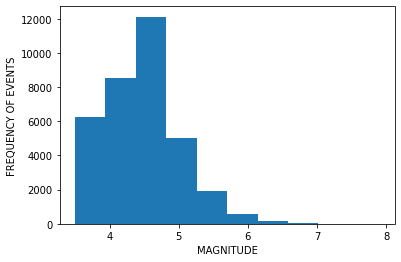

In [ ]:
plt.hist(sulawesi_dataf["MAG"])
plt.xlabel("MAGNITUDE")
plt.ylabel("FREQUENCY OF EVENTS")
plt.show()

T VALUES (SEISMICITY INDICATOR)

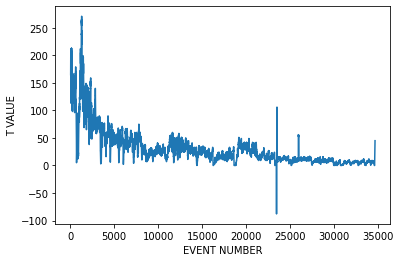

In [ ]:
plt.plot(sulawesi_dataf.loc[60:,("TVAL")])
plt.xlabel("EVENT NUMBER")
plt.ylabel("T VALUE")
plt.show()

MEAN MAGNITUDE (SEISMICITY INDICATOR)

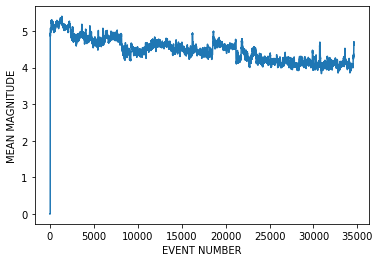

In [ ]:
plt.plot(sulawesi_dataf["MEAN_MAG"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MEAN MAGNITUDE")
plt.show()

ENERGY ((SEISMICITY INDICATOR)

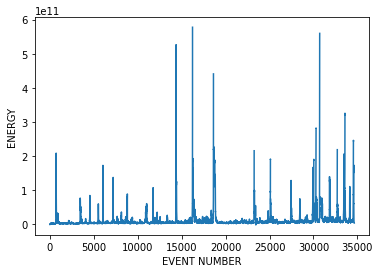

In [ ]:
plt.plot(sulawesi_dataf["ENERGY"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("ENERGY")
plt.show()

ETA VALUE (SEISMICITY INDICATOR)

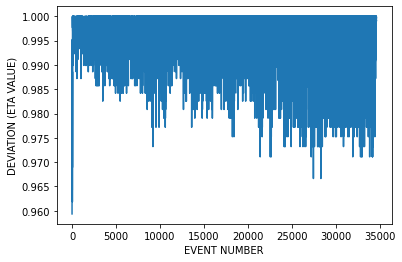

In [ ]:
plt.plot(np.array(sulawesi_dataf["ETA"])*-1)
plt.xlabel("EVENT NUMBER")
plt.ylabel("DEVIATION (ETA VALUE)")
plt.show()

MAGNITUDE DEFICIT (SEISMICITY INDICATOR)

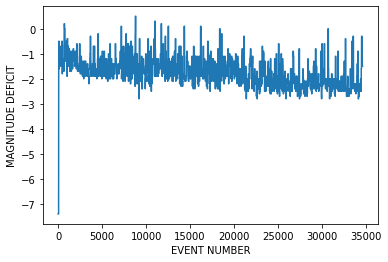

In [ ]:
plt.plot(sulawesi_dataf["MAG_DEF"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MAGNITUDE DEFICIT")
plt.show()

#CENTRAL DATA

**MIN 3.5 DATA**

In [ ]:
central_dataf = pd.read_excel('Central Min3.5 data.xlsx')
central_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1963-02-21,00:00:00,-6.30,106.70,38.0,4.8
1,1963-02-21,00:00:00,-6.30,106.80,33.0,5.2
2,1963-02-22,00:00:00,-6.10,106.30,172.0,4.9
3,1963-03-23,00:00:00,-9.80,114.00,99.0,4.8
4,1963-05-06,00:00:00,-9.20,112.40,80.0,6.1
...,...,...,...,...,...,...
6958,2020-05-10,00:00:00,-8.30,115.99,10.0,4.5
6959,2020-05-11,00:00:00,-8.74,118.39,123.0,4.5
6960,2020-05-12,00:00:00,-8.29,115.99,10.0,4.7
6961,2020-05-14,00:00:00,-9.24,119.20,21.0,4.7


In [ ]:
central_dataf = central_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
central_dataf = central_dataf.astype(convert_dict)

In [ ]:
central_dataf['DATETIME'] = central_dataf["DATE"] + " " + central_dataf["TIME"]
central_dataf['DATETIME'] = pd.to_datetime(central_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
central_dataf["DATE"] = pd.to_datetime(central_dataf["DATE"])

In [ ]:
central_dataf = process_data(central_dataf)

In [ ]:
central_dataf

,DATE,TIME,LATITUDE,LONGITUDE,Depth,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,1963-02-21,00:00:00,-6.30,106.70,38.0,4.8,1963-02-21,0,0.000,0.000000e+00,1.047597,-6.167458,-0.958956,0.00,0.000000,1
1,1963-02-21,00:00:00,-6.30,106.80,33.0,5.2,1963-02-21,0,0.000,0.000000e+00,1.047597,-6.167458,-0.979456,0.00,0.000000,1
2,1963-02-22,00:00:00,-6.10,106.30,172.0,4.9,1963-02-22,0,0.000,0.000000e+00,1.047597,-6.167458,-0.964740,0.00,0.000000,1
3,1963-03-23,00:00:00,-9.80,114.00,99.0,4.8,1963-03-23,0,0.000,0.000000e+00,1.047597,-6.167458,-0.958956,0.00,0.000000,1
4,1963-05-06,00:00:00,-9.20,112.40,80.0,6.1,1963-05-06,0,0.000,0.000000e+00,1.047597,-6.167458,-0.999900,0.00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,2020-05-10,00:00:00,-8.30,115.99,10.0,4.5,2020-05-10,94,4.762,1.751722e+09,1.047597,-0.667458,-0.999954,1.84,1.073748,50
6959,2020-05-11,00:00:00,-8.74,118.39,123.0,4.5,2020-05-11,92,4.758,1.781357e+09,1.047597,-0.667458,-0.999954,1.82,1.081950,50
6960,2020-05-12,00:00:00,-8.29,115.99,10.0,4.7,2020-05-12,92,4.756,1.777497e+09,1.047597,-0.667458,-0.999928,1.82,1.081950,30
6961,2020-05-14,00:00:00,-9.24,119.20,21.0,4.7,2020-05-14,90,4.750,1.796929e+09,1.047597,-0.667458,-0.999928,1.76,1.106874,30


In [ ]:
check_all_nan(central_dataf)

nan not found


In [ ]:
#central_dataf.to_csv("central3.5_dataf.csv")

In [ ]:
central_output = get_output(central_dataf,5.5)
pd_dict = {"OUTPUT":central_output}
central_dataf_output = pd.DataFrame(pd_dict)
central_dataf_output.to_csv("central5.5_output.csv")

In [ ]:
np.unique(np.array(central_dataf_output),return_counts=True)

(array([0, 1]), array([1238, 5725]))

**MIN 4 DATA**

In [ ]:
central2_dataf = pd.read_excel('Central Min4 data.xlsx')
central2_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1963-02-21,00:00:00,-6.30,106.70,38.0,4.8
1,1963-02-21,00:00:00,-6.30,106.80,33.0,5.2
2,1963-02-22,00:00:00,-6.10,106.30,172.0,4.9
3,1963-03-23,00:00:00,-9.80,114.00,99.0,4.8
4,1963-05-06,00:00:00,-9.20,112.40,80.0,6.1
...,...,...,...,...,...,...
11619,2020-05-12,00:00:00,-8.31,115.96,10.0,4.0
11620,2020-05-13,00:00:00,-10.09,119.28,10.0,4.1
11621,2020-05-14,00:00:00,-9.24,119.20,21.0,4.7
11622,2020-05-15,00:00:00,-8.42,119.57,174.0,4.0


In [ ]:
central2_dataf = central2_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
central2_dataf = central2_dataf.astype(convert_dict)

In [ ]:
central2_dataf['DATETIME'] = central2_dataf["DATE"] + " " + central2_dataf["TIME"]
central2_dataf['DATETIME'] = pd.to_datetime(central2_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
central2_dataf["DATE"] = pd.to_datetime(central2_dataf["DATE"])

In [ ]:
central2_dataf = process_data(central2_dataf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
central2_dataf

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,1963-02-21,00:00:00,-6.30,106.70,38.0,4.8,1963-02-21,0,0.000,0.000000e+00,0.689942,-6.521425,-0.971788,0.00,0.000000,1
1,1963-02-21,00:00:00,-6.30,106.80,33.0,5.2,1963-02-21,0,0.000,0.000000e+00,0.689942,-6.521425,-0.983376,0.00,0.000000,1
2,1963-02-22,00:00:00,-6.10,106.30,172.0,4.9,1963-02-22,0,0.000,0.000000e+00,0.689942,-6.521425,-0.974971,0.00,0.000000,1
3,1963-03-23,00:00:00,-9.80,114.00,99.0,4.8,1963-03-23,0,0.000,0.000000e+00,0.689942,-6.521425,-0.971788,0.00,0.000000,1
4,1963-05-06,00:00:00,-9.20,112.40,80.0,6.1,1963-05-06,0,0.000,0.000000e+00,0.689942,-6.521425,-0.998309,0.00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11619,2020-05-12,00:00:00,-8.31,115.96,10.0,4.0,2020-05-12,38,4.450,2.682229e+09,0.689942,-1.221425,-0.999967,0.76,1.166786,50
11620,2020-05-13,00:00:00,-10.09,119.28,10.0,4.1,2020-05-13,38,4.442,2.661425e+09,0.689942,-1.221425,-0.999985,0.74,1.206544,44
11621,2020-05-14,00:00:00,-9.24,119.20,21.0,4.7,2020-05-14,39,4.426,2.521021e+09,0.689942,-1.221425,-0.999370,0.76,1.166786,12
11622,2020-05-15,00:00:00,-8.42,119.57,174.0,4.0,2020-05-15,40,4.434,2.491176e+09,0.689942,-1.221425,-0.999967,0.78,1.128407,50


In [ ]:
check_all_nan(central2_dataf)

nan not found


In [ ]:
#central2_dataf.to_csv("central4_dataf.csv")

**MIN 4.5 DATA**

In [ ]:
central3_dataf = pd.read_excel('Central Min4.5 data.xlsx')
central3_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1963-02-21,00:00:00,-6.30,106.70,38.0,4.8
1,1963-02-21,00:00:00,-6.30,106.80,33.0,5.2
2,1963-02-22,00:00:00,-6.10,106.30,172.0,4.9
3,1963-03-23,00:00:00,-9.80,114.00,99.0,4.8
4,1963-05-06,00:00:00,-9.20,112.40,80.0,6.1
...,...,...,...,...,...,...
6958,2020-05-10,00:00:00,-8.30,115.99,10.0,4.5
6959,2020-05-11,00:00:00,-8.74,118.39,123.0,4.5
6960,2020-05-12,00:00:00,-8.29,115.99,10.0,4.7
6961,2020-05-14,00:00:00,-9.24,119.20,21.0,4.7


In [ ]:
central3_dataf = central3_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
central3_dataf = central3_dataf.astype(convert_dict)

In [ ]:
central3_dataf['DATETIME'] = central3_dataf["DATE"] + " " + central3_dataf["TIME"]
central3_dataf['DATETIME'] = pd.to_datetime(central3_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
central3_dataf["DATE"] = pd.to_datetime(central3_dataf["DATE"])

In [ ]:
central3_dataf = process_data(central3_dataf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
central3_dataf

,Unnamed: 0,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,0,1963-02-21,00:00:00,-6.30,106.70,38.0,4.8,1963-02-21,0,0.000,0.000000e+00,1.047597,-6.167458,-0.958956,0.00,0.000000,1
1,1,1963-02-21,00:00:00,-6.30,106.80,33.0,5.2,1963-02-21,0,0.000,0.000000e+00,1.047597,-6.167458,-0.979456,0.00,0.000000,1
2,2,1963-02-22,00:00:00,-6.10,106.30,172.0,4.9,1963-02-22,0,0.000,0.000000e+00,1.047597,-6.167458,-0.964740,0.00,0.000000,1
3,3,1963-03-23,00:00:00,-9.80,114.00,99.0,4.8,1963-03-23,0,0.000,0.000000e+00,1.047597,-6.167458,-0.958956,0.00,0.000000,1
4,4,1963-05-06,00:00:00,-9.20,112.40,80.0,6.1,1963-05-06,0,0.000,0.000000e+00,1.047597,-6.167458,-0.999900,0.00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,6958,2020-05-10,00:00:00,-8.30,115.99,10.0,4.5,2020-05-10,94,4.762,1.751722e+09,1.047597,-0.667458,-0.999954,1.84,1.073748,50
6959,6959,2020-05-11,00:00:00,-8.74,118.39,123.0,4.5,2020-05-11,92,4.758,1.781357e+09,1.047597,-0.667458,-0.999954,1.82,1.081950,50
6960,6960,2020-05-12,00:00:00,-8.29,115.99,10.0,4.7,2020-05-12,92,4.756,1.777497e+09,1.047597,-0.667458,-0.999928,1.82,1.081950,30
6961,6961,2020-05-14,00:00:00,-9.24,119.20,21.0,4.7,2020-05-14,90,4.750,1.796929e+09,1.047597,-0.667458,-0.999928,1.76,1.106874,30


In [ ]:
check_all_nan(central3_dataf)

nan not found


In [ ]:
#central3_dataf.to_csv("central4.5_dataf.csv")

#CENTRAL DATA VISUALIZATION

GUTENBERG RICHTER LAW VISUALIZATION

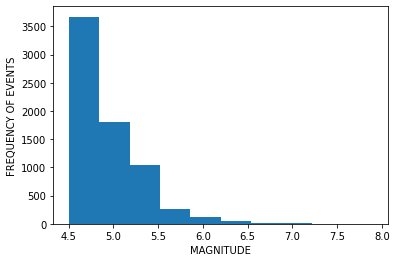

In [ ]:
plt.hist(central_dataf["MAG"])
plt.xlabel("MAGNITUDE")
plt.ylabel("FREQUENCY OF EVENTS")
plt.show()

T VALUES (SEISMICITY INDICATOR)

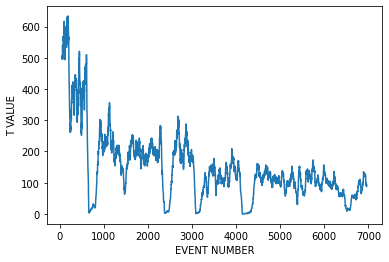

In [ ]:
plt.plot(central_dataf.loc[60:,("TVAL")])
plt.xlabel("EVENT NUMBER")
plt.ylabel("T VALUE")
plt.show()

MEAN MAGNITUDE (SEISMICITY INDICATOR)

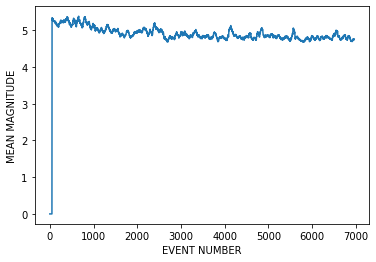

In [ ]:
plt.plot(central_dataf["MEAN_MAG"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MEAN MAGNITUDE")
plt.show()

ENERGY ((SEISMICITY INDICATOR)

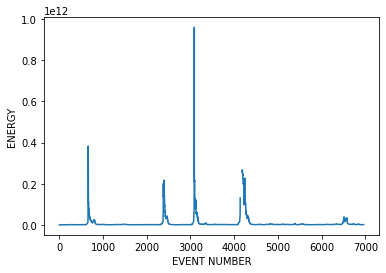

In [ ]:
plt.plot(central_dataf["ENERGY"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("ENERGY")
plt.show()

ETA VALUE (SEISMICITY INDICATOR)

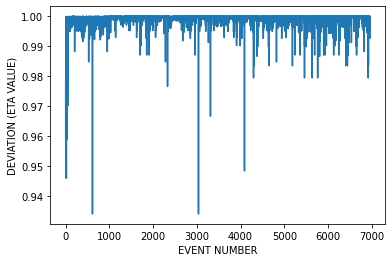

In [ ]:
plt.plot(np.array(central_dataf["ETA"])*-1)
plt.xlabel("EVENT NUMBER")
plt.ylabel("DEVIATION (ETA VALUE)")
plt.show()

MAGNITUDE DEFICIT (SEISMICITY INDICATOR)

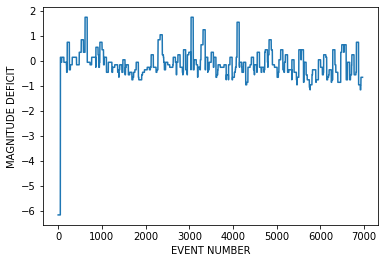

In [ ]:
plt.plot(central_dataf["MAG_DEF"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MAGNITUDE DEFICIT")
plt.show()

#ASIAN DATA

In [ ]:
asian_dataf = pd.read_excel('Asian Data.xlsx')
asian_dataf

,Date,Time,Lat,Long,Depth,Mag
0,1970-01-01,03:29:16.800000,-4.9300,102.7330,58.0,5.4
1,1970-01-03,14:51:48.600000,-3.6840,118.7490,38.0,5.2
2,1970-01-04,17:00:40.200000,24.1390,102.5030,31.0,7.5
3,1970-01-04,17:32:40.200000,24.2020,102.4660,33.0,5.2
4,1970-01-04,18:32:09.500000,24.2740,102.3010,33.0,4.9
...,...,...,...,...,...,...
65331,2018-06-30,08:47:40.740000,36.6114,71.1247,223.2,4.4
65332,2018-06-30,11:27:42.410000,32.6066,50.1973,11.0,4.2
65333,2018-06-30,17:40:32.330000,13.0849,50.9012,16.0,4.3
65334,2018-06-30,17:43:27.330000,13.3060,50.8974,12.0,4.7


**SIMPLE PREPROCESSING**

In [ ]:
asian_dataf = asian_dataf.rename(columns={'Date':'DATE',
                              'Time':'TIME',
                              'Lat':'LATITUDE',
                              'Long':'LONGITUDE',
                              'Depth':'DEPTH',
                              'Mag':'MAG'})

In [ ]:
convert_dict = {"DATE":str,"TIME":str}
asian_dataf = asian_dataf.astype(convert_dict)

In [ ]:
asian_dataf['DATETIME'] = asian_dataf["DATE"] + " " + asian_dataf["TIME"]
asian_dataf['DATETIME'] = pd.to_datetime(asian_dataf["DATETIME"], format='%Y/%m/%d %H:%M:%S')

In [ ]:
asian_dataf["DATE"] = pd.to_datetime(asian_dataf["DATE"])

In [ ]:
asian_dataf

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME
0,1970-01-01,03:29:16.800000,-4.9300,102.7330,58.0,5.4,1970-01-01 03:29:16.800
1,1970-01-03,14:51:48.600000,-3.6840,118.7490,38.0,5.2,1970-01-03 14:51:48.600
2,1970-01-04,17:00:40.200000,24.1390,102.5030,31.0,7.5,1970-01-04 17:00:40.200
3,1970-01-04,17:32:40.200000,24.2020,102.4660,33.0,5.2,1970-01-04 17:32:40.200
4,1970-01-04,18:32:09.500000,24.2740,102.3010,33.0,4.9,1970-01-04 18:32:09.500
...,...,...,...,...,...,...,...
65331,2018-06-30,08:47:40.740000,36.6114,71.1247,223.2,4.4,2018-06-30 08:47:40.740
65332,2018-06-30,11:27:42.410000,32.6066,50.1973,11.0,4.2,2018-06-30 11:27:42.410
65333,2018-06-30,17:40:32.330000,13.0849,50.9012,16.0,4.3,2018-06-30 17:40:32.330
65334,2018-06-30,17:43:27.330000,13.3060,50.8974,12.0,4.7,2018-06-30 17:43:27.330


In [ ]:
asian_dataf = process_data(asian_dataf)

In [ ]:
asian_dataf

,DATE,TIME,LATITUDE,LONGITUDE,DEPTH,MAG,DATETIME,TVAL,MEAN_MAG,ENERGY,b,MAG_DEF,ETA,MU,c,NO_OF_EVENTS
0,1970-01-01,03:29:16.800000,-4.9300,102.7330,58.0,5.4,1970-01-01 03:29:16.800,0.000000,0.000,0.000000e+00,0.31729,-8.475827,-0.980951,0.000000,0.000000,1
1,1970-01-03,14:51:48.600000,-3.6840,118.7490,38.0,5.2,1970-01-03 14:51:48.600,0.000000,0.000,0.000000e+00,0.31729,-8.475827,-0.978393,0.000000,0.000000,1
2,1970-01-04,17:00:40.200000,24.1390,102.5030,31.0,7.5,1970-01-04 17:00:40.200,0.000000,0.000,0.000000e+00,0.31729,-8.475827,-0.998083,0.000000,0.000000,1
3,1970-01-04,17:32:40.200000,24.2020,102.4660,33.0,5.2,1970-01-04 17:32:40.200,0.000000,0.000,0.000000e+00,0.31729,-8.475827,-0.978393,0.000000,0.000000,1
4,1970-01-04,18:32:09.500000,24.2740,102.3010,33.0,4.9,1970-01-04 18:32:09.500,0.000000,0.000,0.000000e+00,0.31729,-8.475827,-0.974255,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65331,2018-06-30,08:47:40.740000,36.6114,71.1247,223.2,4.4,2018-06-30 08:47:40.740,5.101019,4.034,1.030236e+10,0.31729,-3.575827,-0.998280,0.106383,2.925816,10
65332,2018-06-30,11:27:42.410000,32.6066,50.1973,11.0,4.2,2018-06-30 11:27:42.410,5.208600,4.024,9.672284e+09,0.31729,-3.675827,-0.999348,0.106383,2.925816,15
65333,2018-06-30,17:40:32.330000,13.0849,50.9012,16.0,4.3,2018-06-30 17:40:32.330,5.461748,4.024,9.223980e+09,0.31729,-3.675827,-0.998792,0.106383,2.925816,12
65334,2018-06-30,17:43:27.330000,13.3060,50.8974,12.0,4.7,2018-06-30 17:43:27.330,5.458345,4.028,9.301082e+09,0.31729,-3.675827,-0.992896,0.106383,2.925816,4


In [ ]:
check_all_nan(asian_dataf)

nan not found


In [ ]:
#asian_dataf.to_csv("asian_dataf.csv")

In [ ]:
asian_output = get_output(asian_dataf,5.5)
pd_dict = {"OUTPUT":asian_output}
asian_dataf_output = pd.DataFrame(pd_dict)
asian_dataf_output.to_csv("asian5.5_output.csv")

In [ ]:
np.unique(np.array(asian_dataf_output),return_counts=True)

(array([0, 1]), array([30865, 34471]))

#ASIAN DATA VISUALIZATION

GUTENBERG RICHTER LAW VISUALIZATION

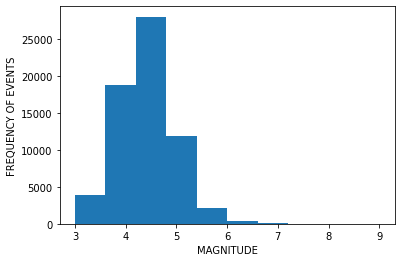

In [105]:
plt.hist(asian_dataf["MAG"])
plt.xlabel("MAGNITUDE")
plt.ylabel("FREQUENCY OF EVENTS")
plt.show()

T VALUES (SEISMICITY INDICATOR)

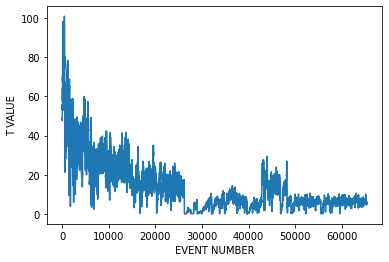

In [106]:
plt.plot(asian_dataf.loc[60:,("TVAL")])
plt.xlabel("EVENT NUMBER")
plt.ylabel("T VALUE")
plt.show()

MEAN MAGNITUDE (SEISMICITY INDICATOR)

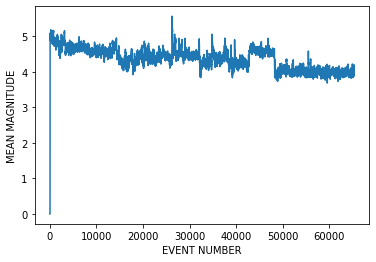

In [107]:
plt.plot(asian_dataf["MEAN_MAG"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MEAN MAGNITUDE")
plt.show()

ENERGY ((SEISMICITY INDICATOR)

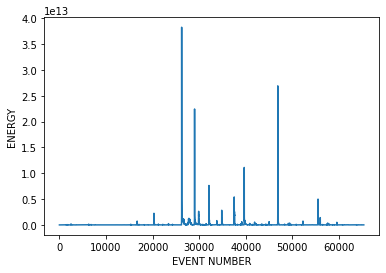

In [108]:
plt.plot(asian_dataf["ENERGY"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("ENERGY")
plt.show()

ETA VALUE (SEISMICITY INDICATOR)

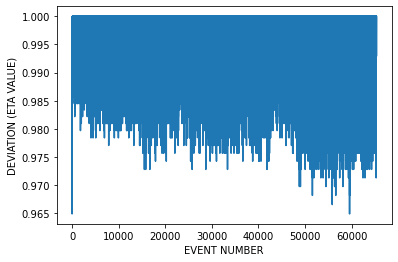

In [109]:
plt.plot(np.array(asian_dataf["ETA"])*-1)
plt.xlabel("EVENT NUMBER")
plt.ylabel("DEVIATION (ETA VALUE)")
plt.show()

MAGNITUDE DEFICIT (SEISMICITY INDICATOR)

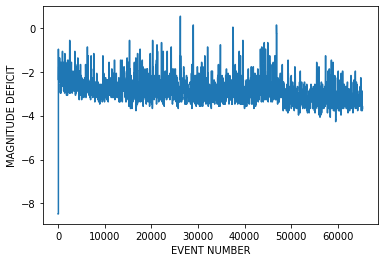

In [110]:
plt.plot(asian_dataf["MAG_DEF"])
plt.xlabel("EVENT NUMBER")
plt.ylabel("MAGNITUDE DEFICIT")
plt.show()

#TRAINING MODELS


##PREPROCESSING FOR TRAINING

In [ ]:
final_himalaya = pd.read_csv("himalaya_dataf.csv",index_col=0)
final_sumatra = pd.read_csv("sumatra_dataf.csv",index_col=0)
final_central = pd.read_csv("central3.5_dataf.csv",index_col=0)
final_sulawesi = pd.read_csv("sulawesi3.5_dataf.csv",index_col=0)
final_asian = pd.read_csv("asian_dataf.csv",index_col=0)

In [ ]:
final_himalaya = final_himalaya[N:][["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_sumatra = final_sumatra[N:][["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_central = final_central[N:][["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_sulawesi = final_sulawesi[N:][["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_asian = final_asian[N:][["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]

In [ ]:
final_himalaya_output = pd.read_csv("himalaya5.5_output.csv",index_col=0)
final_sumatra_output = pd.read_csv("sumatra5.5_output.csv",index_col=0)
final_central_output = pd.read_csv("central5.5_output.csv",index_col=0)
final_sulawesi_output = pd.read_csv("sulawesi5.5_output.csv",index_col=0)
final_asian_output = pd.read_csv("asian5.5_output.csv",index_col=0)

In [ ]:
final_himalaya_output = final_himalaya_output[N:]
final_sumatra_output = final_sumatra_output[N:]
final_central_output = final_central_output[N:]
final_sulawesi_output = final_sulawesi_output[N:]
final_asian_output = final_asian_output[N:]

In [ ]:
final_himalaya = final_himalaya.astype(np.double)
final_sumatra = final_sumatra.astype(np.double)
final_central = final_central.astype(np.double)
final_sulawesi = final_sulawesi.astype(np.double)
final_asian = final_asian.astype(np.double)

In [28]:
temp_sumatra = pd.concat((final_sumatra,final_sumatra_output),axis=1)
temp_central = pd.concat((final_central,final_central_output),axis=1)
temp_sulawesi = pd.concat((final_sulawesi,final_sulawesi_output),axis=1)
temp_asian = pd.concat((final_asian,final_asian_output),axis=1)

In [29]:
temp_sumatra = temp_sumatra.replace([np.inf,-np.inf],np.nan).dropna()
temp_central = temp_central.replace([np.inf,-np.inf],np.nan).dropna()
temp_sulawesi = temp_sulawesi.replace([np.inf,-np.inf],np.nan).dropna()
temp_asian = temp_asian.replace([np.inf,-np.inf],np.nan).dropna()

In [30]:
final_sumatra_1 = temp_sumatra[["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_central_1 = temp_central[["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_sulawesi_1 = temp_sulawesi[["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]
final_asian_1 = temp_asian[["TVAL","MEAN_MAG","ENERGY","b","MAG_DEF","ETA","MU","c"]]

In [31]:
scaler_sumatra = MinMaxScaler()
scaler_central = MinMaxScaler()
scaler_sulawesi = MinMaxScaler()
scaler_asian = MinMaxScaler()

In [32]:
final_sumatra_s1 = final_sumatra_1.copy(deep=True)
final_central_s1 = final_central_1.copy(deep=True)
final_sulawesi_s1 = final_sulawesi_1.copy(deep=True)
final_asian_s1 = final_asian_1.copy(deep=True)

In [33]:
final_sumatra_s1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]] = scaler_sumatra.fit_transform(final_sumatra_1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]])
final_central_s1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]] = scaler_central.fit_transform(final_central_1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]])
final_sulawesi_s1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]] = scaler_sulawesi.fit_transform(final_sulawesi_1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]])
final_asian_s1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]] = scaler_asian.fit_transform(final_asian_1[["TVAL","MEAN_MAG","ENERGY","MAG_DEF","ETA","MU","c"]])

In [34]:
# final_sumatra_s1[["TVAL","ENERGY"]] = scaler_sumatra.fit_transform(final_sumatra_1[["TVAL","ENERGY"]])
# final_central_s1[["TVAL","ENERGY"]] = scaler_central.fit_transform(final_central_1[["TVAL","ENERGY"]])
# final_sulawesi_s1[["TVAL","ENERGY"]] = scaler_sulawesi.fit_transform(final_sulawesi_1[["TVAL","ENERGY"]])
# final_asian_s1[["TVAL","ENERGY"]] = scaler_asian.fit_transform(final_asian_1[["TVAL","ENERGY"]])

In [40]:
final_sumatra_output_1 = temp_sumatra[["OUTPUT"]]
final_central_output_1 = temp_central[["OUTPUT"]]
final_sulawesi_output_1 = temp_sulawesi[["OUTPUT"]]
final_asian_output_1 = temp_asian[["OUTPUT"]]

In [ ]:
X_train_sumatra,X_val_sumatra,Y_train_sumatra,Y_val_sumatra = train_test_split(final_sumatra_s1,final_sumatra_output_1,stratify=final_sumatra_output_1,random_state=0)
X_train_central,X_val_central,Y_train_central,Y_val_central = train_test_split(final_central_s1,final_central_output_1,stratify=final_central_output_1,random_state=0)
X_train_sulawesi,X_val_sulawesi,Y_train_sulawesi,Y_val_sulawesi = train_test_split(final_sulawesi_s1,final_sulawesi_output_1,stratify=final_sulawesi_output_1,random_state=0)
X_train_asian,X_val_asian,Y_train_asian,Y_val_asian = train_test_split(final_asian_s1,final_asian_output_1,stratify=final_asian_output_1,random_state=0)

In [43]:
X_train_sumatra,X_val_sumatra,Y_train_sumatra,Y_val_sumatra = map(np.array,(X_train_sumatra,X_val_sumatra,Y_train_sumatra,Y_val_sumatra))
X_train_central,X_val_central,Y_train_central,Y_val_central = map(np.array,(X_train_central,X_val_central,Y_train_central,Y_val_central))
X_train_sulawesi,X_val_sulawesi,Y_train_sulawesi,Y_val_sulawesi = map(np.array,(X_train_sulawesi,X_val_sulawesi,Y_train_sulawesi,Y_val_sulawesi))
X_train_asian,X_val_asian,Y_train_asian,Y_val_asian = map(np.array,(X_train_asian,X_val_asian,Y_train_asian,Y_val_asian))

In [44]:
X_train_sumatra,X_val_sumatra,Y_train_sumatra,Y_val_sumatra = map(torch.Tensor,(X_train_sumatra,X_val_sumatra,Y_train_sumatra,Y_val_sumatra))
X_train_central,X_val_central,Y_train_central,Y_val_central = map(torch.Tensor,(X_train_central,X_val_central,Y_train_central,Y_val_central))
X_train_sulawesi,X_val_sulawesi,Y_train_sulawesi,Y_val_sulawesi = map(torch.Tensor,(X_train_sulawesi,X_val_sulawesi,Y_train_sulawesi,Y_val_sulawesi))
X_train_asian,X_val_asian,Y_train_asian,Y_val_asian = map(torch.Tensor,(X_train_asian,X_val_asian,Y_train_asian,Y_val_asian))

##SUMATRA

In [89]:
class earthquake_model_sumatra(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8,4),
            nn.ReLU(),
            nn.Linear(4,4),
            nn.ReLU(),
            nn.Linear(4,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

In [90]:
model_sumatra = earthquake_model_sumatra()

Iteration 995 Loss 0.5277016162872314


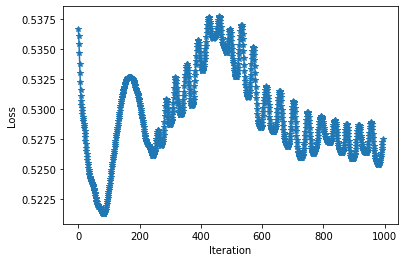




The loss before training is0.53666752576828
The loss after training istensor(0.4502, grad_fn=<BinaryCrossEntropyBackward>)


In [93]:
l_sumatra,b_sumatra = fit_optim(model_sumatra,X_train_sumatra,Y_train_sumatra,1000,0.0001,128)

Iteration 495 Loss 0.5033876895904541


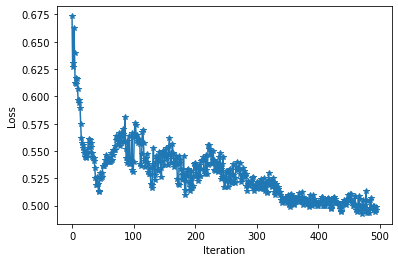




The loss before training is0.6733927130699158
The loss after training istensor(0.4289, grad_fn=<BinaryCrossEntropyBackward>)


In [ ]:
l_sumatra,b_sumatra = fit_optim(model_sumatra,X_train_sumatra,Y_train_sumatra,500,0.0001,128)

In [94]:
calc_metric2(b_sumatra,X_val_sumatra,Y_val_sumatra)

The f1 accuracy is 0.8129189518586227


In [100]:
# torch.save(b_sumatra,"sumatra_model_3(f81%)")

##CENTRAL

In [ ]:
class earthquake_model_central(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8,24),
            nn.ReLU(),
            nn.Linear(24,24),
            nn.ReLU(),
            nn.Linear(24,12),
            nn.ReLU(),
            nn.Linear(12,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

In [ ]:
model_central = earthquake_model_central()

Iteration 195 Loss 0.2824236750602722


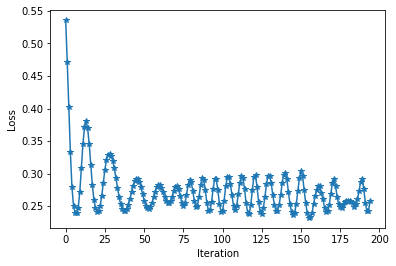




The loss before training is0.5357078909873962
The loss after training istensor(0.1993, grad_fn=<BinaryCrossEntropyBackward>)


In [ ]:
l_central,b_central = fit_optim(model_central,X_train_central,Y_train_central,200,0.0001,64)

In [ ]:
calc_metric(b_central,X_val_central,Y_val_central)

The accuracy is  82.01396973224679
The confusion matrix is
 [[   0  309]
 [   0 1409]]
The f1 score is 0.9011832427246562


In [88]:
calc_metric2(b_central,X_val_central,Y_val_central)

The f1 accuracy is 0.9011832427246562


In [ ]:
#torch.save(b_central,"central_model_1(82%)")

##SULAWESI

Iteration 2995 Loss 0.52061527967453


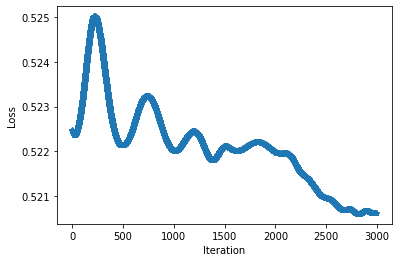




The loss before training is0.522469162940979
The loss after training istensor(0.5006, grad_fn=<BinaryCrossEntropyBackward>)


In [ ]:
l_sulawesi,b_sulawesi = fit_optim(model_sulawesi,X_train_sulawesi,Y_train_sulawesi,3000,0.00001,4096)

In [ ]:
calc_metric(b_sulawesi,X_val_sulawesi,Y_val_sulawesi)

The accuracy is  74.20072608033728
The confusion matrix is
 [[2513 1314]
 [ 889 3823]]
The f1 score is 0.776322469286222


In [ ]:
torch.save(b_sulawesi,"sulawesi_model_1(74%)")

In [95]:
class earthquake_model_sulawesi(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8,14),
            nn.ReLU(),
            nn.Linear(14,12),
            nn.ReLU(),
            nn.Linear(12,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

In [96]:
model_sulawesi = earthquake_model_sulawesi()

Iteration 495 Loss 0.6037675738334656


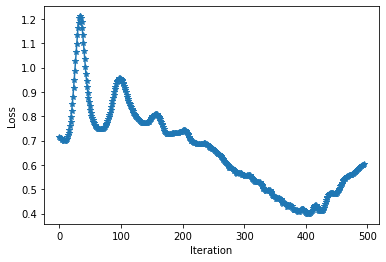




The loss before training is0.7128465175628662
The loss after training istensor(0.3021, grad_fn=<BinaryCrossEntropyBackward>)


In [97]:
l_sulawesi,b_sulawesi = fit_optim(model_sulawesi,X_train_sulawesi,Y_train_sulawesi,500,0.0001,64)

In [98]:
calc_metric(b_sulawesi,X_val_sulawesi,Y_val_sulawesi)

The accuracy is  76.88073394495413
The confusion matrix is
 [[  0 250]
 [  2 838]]
The f1 score is 0.8692946058091287


In [99]:
calc_metric2(b_sulawesi,X_val_sulawesi,Y_val_sulawesi)

The f1 accuracy is 0.8692946058091287


In [101]:
#torch.save(b_sulawesi,"sulawesi_model_2(f86%)")

##ASIAN


In [72]:
class earthquake_model_asian(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8,12),
            nn.ReLU(),
            nn.Linear(12,12),
            nn.ReLU(),
            nn.Linear(12,12),
            nn.ReLU(),
            nn.Linear(12,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

In [75]:
model_asian = earthquake_model_asian()

Iteration 7995 Loss 0.556225597858429


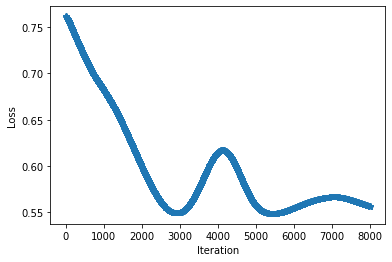




The loss before training is0.7616449594497681
The loss after training istensor(0.5195, grad_fn=<BinaryCrossEntropyBackward>)


In [76]:
l_asian,b_asian = fit_optim(model_asian,X_train_asian,Y_train_asian,8000,0.00001,256)

In [86]:
calc_metric2(b_asian,X_val_asian,Y_val_asian)

The f1 accuracy is 0.8557046979865772


In [84]:
#torch.save(b_asian,"asian_model_2(f85.57%)")